# Tâche 3 DEFT 2009: Classification par parti politique d’interventions au Parlement européen.

## 1. Imports

In [44]:
# Librairies Standard
import os
import xml.etree.ElementTree as ET

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

# Gensim (Word2Vec et Doc2Vec)
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Data & DataViz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## 2. Récupération du corpus

Pour le corpus de test, les données textuelles et les métadonnées sont stockées dans des fichiers différents. Il convient donc d'associer chaque document à ses métadonnées.

In [3]:
dossier_train = "../../deft09/corpus_train"
dossier_test = "../../deft09/corpus_test"
dossier_ref = "../../deft09/donnees_ref"

In [4]:
def recup_train_data(dossier) : 
    """
    extraction du texte et des étiquettes des documents XML d'un répertoire.
    """
    train_textes = []
    labels_train = []
    for fichier in os.listdir(dossier) : 
        if fichier.endswith(".xml"):
            chemin_fichier = os.path.join(dossier, fichier)
            tree = ET.parse(chemin_fichier) #analyse et parsing du fichier
            root = tree.getroot() #obtient l'élément racine de l'arbre XML (le noeud principal de l'arbre)

            for doc in root.findall("doc") : 
                intervention = doc.find(".//texte/p")
                if intervention is not None and intervention.text is not None : 
                    texte = intervention.text
                else : 
                    texte = ""
                parti = doc.find(".//EVALUATION/EVAL_PARTI/PARTI")
                if parti is not None and "valeur" in parti.attrib : 
                    label = parti.get("valeur")
                else : 
                    label = "Unknown"

                train_textes.append(texte)
                labels_train.append(label)
                
    print(f"Nb textes train : {len(train_textes)}")
    print(f"Nb labels train : {len(labels_train)}")

    return train_textes, labels_train

def recup_test_data(dossier) : 
    """
    extraction du texte des documents XML d'un répertoire.
    """
    test_textes = []
    for fichier in os.listdir(dossier) : 
        if fichier.endswith(".xml"):
            chemin_fichier = os.path.join(dossier, fichier)

            tree = ET.parse(chemin_fichier) #analyse et parsing du fichier
            root = tree.getroot() #obtient l'élément racine de l'arbre XML (le noeud principal de l'arbre)

            for doc in root.findall('doc'):
                texte_complet = ""
                for p in doc.find('texte').findall('p'):
                    if p.text : 
                        texte_complet += p.text.strip() + " "
                test_textes.append(texte_complet.strip())

    print(f"Nb textes test : {len(test_textes)}")

    return test_textes
    
def recup_donnees_ref(dossier) :
    """
    extraction des étiquettes des documents XML d'un répertoire.
    """
    labels_test = []
    for fichier in os.listdir(dossier) : 
        if fichier.endswith(".txt"):
            chemin_fichier = os.path.join(dossier, fichier)

            with open(chemin_fichier, "r", encoding="latin1") as file : 
                for ligne in file : 
                    ligne = ligne.strip()
                    ligne = ligne.replace("\t", " ")
                    parties = ligne.split()
                    if len(parties) > 1: 
                        labels_test.append(parties[1])
                    else:
                        print(f"Ligne ignorée : {ligne} sur le fichier {fichier}")
                        labels_test.append("Unknown")

    print(f"Nb labels test : {len(labels_test)}")
    
    return labels_test

In [5]:
textes_train, y_train = recup_train_data(dossier_train)

Nb textes train : 19370
Nb labels train : 19370


In [6]:
textes_test = recup_test_data(dossier_test)
y_test = recup_donnees_ref(dossier_ref)

Nb textes test : 12917
Ligne ignorée : 1175 sur le fichier deft09_parlement_ref_fr.txt
Ligne ignorée : 4574 sur le fichier deft09_parlement_ref_fr.txt
Nb labels test : 12917


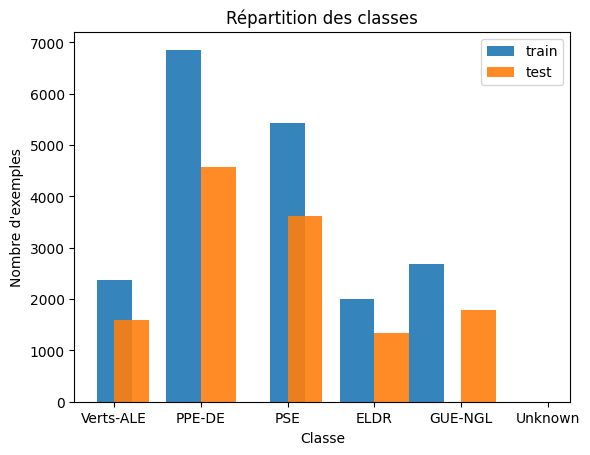

In [ ]:
#Répartition des classes dans train et test

plt.hist(y_train, alpha=0.9, align="left", width=0.4, label='train')
plt.hist(y_test, alpha=0.9, align="mid", width=0.4, label='test')
plt.legend()
plt.xlabel("Classe")
plt.ylabel("Nombre d'exemples")
plt.title("Répartition des classes") 
plt.show()

## 3. Preprocessing

### Retrait des stopwords

In [8]:
stopwords_list = stopwords.words("french")

## 4. Test des méthodes de l'expérience de 2009

### Vectorisation avec tf-idf

In [ ]:
tfidf = TfidfVectorizer(stop_words=stopwords_list)
X_train = tfidf.fit_transform(textes_train)
X_test = tfidf.transform(textes_test)

### Avec KNeighbors Classifier

In [ ]:
param_gridKNN = {
    "n_neighbors" : [15],
    "weights" : ["distance"], 
}

#Initialisation
KNN = KNeighborsClassifier()
KNN_grid = GridSearchCV(KNN, param_gridKNN, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
KNN_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", KNN_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_KNN = KNN_grid.best_estimator_
y_pred_best_KNN = best_KNN.predict(X_test)

#Résultats
print("Rapport de Classification KNeighbors Classifier:\n")
print(classification_report(y_test, y_pred_best_KNN))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...................n_neighbors=15, weights=distance; total time=  36.1s
[CV] END ...................n_neighbors=15, weights=distance; total time=  35.9s
[CV] END ...................n_neighbors=15, weights=distance; total time=  40.2s
[CV] END ...................n_neighbors=15, weights=distance; total time=  44.2s
[CV] END ...................n_neighbors=15, weights=distance; total time=  46.9s
Meilleurs paramètres :  {'n_neighbors': 15, 'weights': 'distance'}
Rapport de Classification KNeighbors Classifier:



/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        ELDR       0.13      0.01      0.03      4017
     GUE-NGL       0.14      0.01      0.03      5379
      PPE-DE       0.38      0.03      0.06     13713
         PSE       0.28      0.93      0.43     10881
     Unknown       0.00      0.00      0.00         6
   Verts-ALE       0.10      0.01      0.02      4755

    accuracy                           0.28     38751
   macro avg       0.17      0.17      0.09     38751
weighted avg       0.26      0.28      0.15     38751



/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Avec Multinomial Naive Bayes

In [ ]:
param_gridMultiNB = {
    "alpha": [0.05, 0.2, 0.7, 1.0, 2],
    "fit_prior": [True, False]
}

#Initialisation
MultiNB = MultinomialNB()
MultiNB_grid = GridSearchCV(MultiNB, param_gridMultiNB, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
MultiNB_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", MultiNB_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_MultiNB = MultiNB_grid.best_estimator_
y_pred_best_MultiNB = best_MultiNB.predict(X_test)

#Résultats
print("Rapport de Classification Multinomial Naive Bayes:\n")
print(classification_report(y_test, y_pred_best_MultiNB))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .........................alpha=0.05, fit_prior=True; total time=   0.4s
[CV] END .........................alpha=0.05, fit_prior=True; total time=   0.5s
[CV] END .........................alpha=0.05, fit_prior=True; total time=   0.5s
[CV] END .........................alpha=0.05, fit_prior=True; total time=   0.6s
[CV] END .........................alpha=0.05, fit_prior=True; total time=   0.6s
[CV] END ........................alpha=0.05, fit_prior=False; total time=   0.5s
[CV] END ........................alpha=0.05, fit_prior=False; total time=   0.6s
[CV] END ........................alpha=0.05, fit_prior=False; total time=   0.4s
[CV] END ........................alpha=0.05, fit_prior=False; total time=   0.5s
[CV] END ........................alpha=0.05, fit_prior=False; total time=   0.5s
[CV] END ..........................alpha=0.2, fit_prior=True; total time=   0.4s
[CV] END ..........................alpha=0.2, fi

/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        ELDR       0.35      0.06      0.10      4017
     GUE-NGL       0.31      0.29      0.30      5379
      PPE-DE       0.41      0.65      0.50     13713
         PSE       0.37      0.34      0.35     10881
     Unknown       0.00      0.00      0.00         6
   Verts-ALE       0.35      0.10      0.16      4755

    accuracy                           0.38     38751
   macro avg       0.30      0.24      0.24     38751
weighted avg       0.37      0.38      0.35     38751



/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 5. Test de nouveaux algorithmes

En gardant le même preprocessing, nous avons voulu tester d'autres algorithmes que ceux testés en 2009.

### a. Complement Naive Bayes

In [ ]:
param_gridComplNB = {
    "alpha": [0.05, 0.2, 0.7, 1.0, 2],
    "fit_prior": [True, False],
    "norm": [True, False]
}

#Initialisation
ComplNB = ComplementNB()
ComplNB_grid = GridSearchCV(ComplNB, param_gridComplNB, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
ComplNB_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", ComplNB_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_ComplNB = ComplNB_grid.best_estimator_
y_pred_best_ComplNB = best_ComplNB.predict(X_test)

#Résultats
print("Rapport de Classification Complement Naive Bayes :\n")
print(classification_report(y_test, y_pred_best_ComplNB))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ..............alpha=0.05, fit_prior=True, norm=True; total time=   0.4s
[CV] END ..............alpha=0.05, fit_prior=True, norm=True; total time=   0.4s
[CV] END ..............alpha=0.05, fit_prior=True, norm=True; total time=   0.5s
[CV] END ..............alpha=0.05, fit_prior=True, norm=True; total time=   0.5s
[CV] END ..............alpha=0.05, fit_prior=True, norm=True; total time=   0.4s
[CV] END .............alpha=0.05, fit_prior=True, norm=False; total time=   0.4s
[CV] END .............alpha=0.05, fit_prior=True, norm=False; total time=   0.4s
[CV] END .............alpha=0.05, fit_prior=True, norm=False; total time=   0.3s
[CV] END .............alpha=0.05, fit_prior=True, norm=False; total time=   0.7s
[CV] END .............alpha=0.05, fit_prior=True, norm=False; total time=   0.7s
[CV] END .............alpha=0.05, fit_prior=False, norm=True; total time=   0.7s
[CV] END .............alpha=0.05, fit_prior=Fal

/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        ELDR       0.36      0.05      0.09      4017
     GUE-NGL       0.36      0.22      0.28      5379
      PPE-DE       0.40      0.71      0.51     13713
         PSE       0.37      0.32      0.34     10881
     Unknown       0.00      0.00      0.00         6
   Verts-ALE       0.36      0.07      0.12      4755

    accuracy                           0.39     38751
   macro avg       0.31      0.23      0.22     38751
weighted avg       0.38      0.39      0.34     38751



/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### b. SVM

In [46]:
param_gridSVM = { 
    "C" : [0.2, 1, 10],
    "dual": [True, False],
    "class_weight" : ["balanced", None],
    "max_iter" : [700, 1000]
}

#Initialisation
svm = LinearSVC()
svm_grid = GridSearchCV(svm, param_gridSVM, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
svm_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", svm_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_svm = svm_grid.best_estimator_
y_pred_best_svm = best_svm.predict(X_test)

#Résultats
print("Rapport de Classification SVM :\n")
print(classification_report(y_test, y_pred_best_svm))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=   6.4s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=   6.4s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=   6.5s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=   6.6s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=   5.8s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time=   5.7s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time=   5.9s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time=   5.8s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time=   5.6s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time=   5.7s
[CV] END C=0.2, class_weight=balanced, dual=False, max_iter=700; total time=  17.3s
[CV] END C=0.2, cla

/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 1.5min


/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 1.6min


/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 1.5min


/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 1.6min


/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 1.5min
[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 1.5min
[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 1.5min
[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 1.7min
[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 1.5min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.2min
[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 1.6min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.1min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.0min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.2min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time= 1.1min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.3min
[CV]

/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        ELDR       0.28      0.09      0.14      4017
     GUE-NGL       0.31      0.31      0.31      5379
      PPE-DE       0.42      0.60      0.49     13713
         PSE       0.36      0.35      0.36     10881
     Unknown       0.00      0.00      0.00         6
   Verts-ALE       0.30      0.13      0.18      4755

    accuracy                           0.38     38751
   macro avg       0.28      0.25      0.25     38751
weighted avg       0.36      0.38      0.35     38751



/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### c. Logistic Regression 

In [15]:
param_gridLR = { 
    "C" : [0.2, 1, 10],
    "class_weight" : ["balanced", None],
    "max_iter" : [1000, 2000]
}

#Initialisation
LR = LogisticRegression()
LR_grid = GridSearchCV(LR, param_gridLR, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
LR_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", LR_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_LR = LR_grid.best_estimator_
y_pred_best_LR = best_LR.predict(X_test)

#Résultats
print("Rapport de Classification Logistic Regression :\n")
print(classification_report(y_test, y_pred_best_LR))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=  56.0s
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time= 1.0min
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time= 1.0min
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time= 1.2min
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time= 1.2min
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time= 1.3min
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time= 1.3min
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time= 1.4min
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time= 1.0min
[CV] END ............C=0.2, class_weight=None, max_iter=1000; total time= 1.1min
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time= 1.3min
[CV] END ............C=0.2, class_weight=None, m

/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        ELDR       0.10      0.03      0.04      4017
     GUE-NGL       0.14      0.13      0.14      5379
      PPE-DE       0.36      0.53      0.43     13713
         PSE       0.28      0.28      0.28     10881
     Unknown       0.00      0.00      0.00         6
   Verts-ALE       0.14      0.05      0.07      4755

    accuracy                           0.29     38751
   macro avg       0.17      0.17      0.16     38751
weighted avg       0.25      0.29      0.26     38751



/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### d. Random Forest

Avec notre matériel, l'exécution de la cellule suivante pour effectuer de Grid Search sur Random Forest a pris 100minutes soit 1h40.
De plus, les résultats ne sont pas intéressants car moins bons que d'autres méthodes.

Nous ne trouvons donc pas pertinent d'exécuter la cellule suivante et vous le déconseillons donc.

In [17]:
# param_gridRF = {
#     "n_estimators" : [50, 100], 
#     "max_depth" : [100, 250], 
#     "min_samples_split" : [2, 5], 
# }

# #Initialisation
# RF = RandomForestClassifier(random_state=42)
# RF_grid = GridSearchCV(RF, param_gridRF, cv=5, verbose=2, n_jobs=-1)

# #Entraînement du modèle
# RF_grid.fit(X_train, y_train)

# #Afficher les meilleurs paramètres
# print("Meilleurs paramètres : ", RF_grid.best_params_)

# #Prédiction avec les meilleurs paramètres obtenus
# best_RF = RF_grid.best_estimator_
# y_pred_best_RF = best_RF.predict(X_test)

# #Résultats
# print("Rapport de Classification Random Forest :\n")
# print(classification_report(y_test, y_pred_best_RF))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=100, min_samples_split=2, n_estimators=50; total time= 8.2min
[CV] END max_depth=100, min_samples_split=2, n_estimators=50; total time= 8.4min
[CV] END max_depth=100, min_samples_split=2, n_estimators=50; total time= 8.5min
[CV] END max_depth=100, min_samples_split=2, n_estimators=50; total time= 8.7min
[CV] END max_depth=100, min_samples_split=2, n_estimators=50; total time= 8.8min
[CV] END max_depth=100, min_samples_split=5, n_estimators=50; total time= 6.2min
[CV] END max_depth=100, min_samples_split=5, n_estimators=50; total time= 6.2min
[CV] END max_depth=100, min_samples_split=5, n_estimators=50; total time= 6.3min
[CV] END max_depth=100, min_samples_split=2, n_estimators=100; total time=16.2min
[CV] END max_depth=100, min_samples_split=2, n_estimators=100; total time=16.3min
[CV] END max_depth=100, min_samples_split=2, n_estimators=100; total time=17.3min
[CV] END max_depth=100, min_samples_split=5, n

/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        ELDR       0.10      0.01      0.02      4017
     GUE-NGL       0.14      0.15      0.14      5379
      PPE-DE       0.35      0.67      0.46     13713
         PSE       0.28      0.15      0.20     10881
     Unknown       0.00      0.00      0.00         6
   Verts-ALE       0.12      0.01      0.02      4755

    accuracy                           0.30     38751
   macro avg       0.17      0.17      0.14     38751
weighted avg       0.25      0.30      0.24     38751



/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 6. Test de nouvelles vectorisations

Les résultats de 2009 laissant à penser que les mauvais résultats obtenus étaient en partie dus aux traits discriminants sélectionnées, nous avons voulu tester d'autres méthodes de vectorisation avec les algorithmes précédemment testés.

Nous avons sélectionné 3 vectorisations à tester :

- tf-idf vectoriser prenant en compte le contexte avec des bigrammes
- Word2Vec
- Doc2Vec

### tf-idf Vectoriser & bigrammes

In [ ]:
tfidf = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(1,2))
X_train = tfidf.fit_transform(textes_train)
X_test = tfidf.transform(textes_test)

#### tf-idf Vectoriser &  + KNN

In [ ]:
param_gridKNN = {
    "n_neighbors" : [1, 2, 10, 15],
    "weights" : ["uniform", "distance"], 
}

#Initialisation
KNN = KNeighborsClassifier()
KNN_grid = GridSearchCV(KNN, param_gridKNN, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
KNN_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", KNN_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_KNN = KNN_grid.best_estimator_
y_pred_best_KNN = best_KNN.predict(X_test)

#Résultats
print("Rapport de Classification KNeighbors Classifier:\n")
print(classification_report(y_test, y_pred_best_KNN))

#### tf-idf Vectoriser &  + MultiNB

In [ ]:
param_gridMultiNB = {
    "alpha": [0.05, 0.2, 0.7, 1.0, 2],
    "fit_prior": [True, False]
}

#Initialisation
MultiNB = MultinomialNB()
MultiNB_grid = GridSearchCV(MultiNB, param_gridMultiNB, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
MultiNB_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", MultiNB_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_MultiNB = MultiNB_grid.best_estimator_
y_pred_best_MultiNB = best_MultiNB.predict(X_test)

#Résultats
print("Rapport de Classification Multinomial Naive Bayes:\n")
print(classification_report(y_test, y_pred_best_MultiNB))

#### tf-idf Vectoriser &  + ComplNB

In [ ]:
param_gridComplNB = {
    "alpha": [0.05, 0.2, 0.7, 1.0, 2],
    "fit_prior": [True, False],
    "norm": [True, False]
}

#Initialisation
ComplNB = ComplementNB()
ComplNB_grid = GridSearchCV(ComplNB, param_gridComplNB, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
ComplNB_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", ComplNB_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_ComplNB = ComplNB_grid.best_estimator_
y_pred_best_ComplNB = best_ComplNB.predict(X_test)

#Résultats
print("Rapport de Classification Complement Naive Bayes :\n")
print(classification_report(y_test, y_pred_best_ComplNB))


#### tf-idf Vectoriser & bigrammes  + SVM

In [ ]:
param_gridSVM = { 
    "C" : [0.2, 1, 10],
    "dual": [True, False],
    "class_weight" : ["balanced", None],
    "max_iter" : [700, 1000]
}

#Initialisation
svm = LinearSVC()
svm_grid = GridSearchCV(svm, param_gridSVM, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
svm_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", svm_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_svm = svm_grid.best_estimator_
y_pred_best_svm = best_svm.predict(X_test)

#Résultats
print("Rapport de Classification SVM :\n")
print(classification_report(y_test, y_pred_best_svm))

#### tf-idf Vectoriser & bigrammes + Logistic Regression

In [ ]:
param_gridLR = { 
    "C" : [0.2, 1, 10],
    "class_weight" : ["balanced", None],
    "max_iter" : [1000, 2000]
}

#Initialisation
LR = LogisticRegression()
LR_grid = GridSearchCV(LR, param_gridLR, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
LR_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", LR_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_LR = LR_grid.best_estimator_
y_pred_best_LR = best_LR.predict(X_test)

#Résultats
print("Rapport de Classification Logistic Regression :\n")
print(classification_report(y_test, y_pred_best_LR))

### Comparaison des performances des modèles tf-idf + bigrammes

In [ ]:
# comparaison des performances des modèles
resultats = pd.DataFrame({
    "Modèle" : ["KNeighbors Classifier", "Multinomial Naive Bayes", "Complement Naive Bayes", "SVM", "Logistic Regression"],
    "Accuracy" : [
        accuracy_score(y_test, y_pred_best_KNN), 
        accuracy_score(y_test, y_pred_best_MultiNB), 
        accuracy_score(y_test, y_pred_best_ComplNB), 
        accuracy_score(y_test, y_pred_best_svm),
        accuracy_score(y_test, y_pred_best_LR)],
    "Precision" : [
        precision_score(y_test, y_pred_best_KNN, average="weighted"), 
        precision_score(y_test, y_pred_best_MultiNB, average="weighted"), 
        precision_score(y_test, y_pred_best_ComplNB, average="weighted"), 
        precision_score(y_test, y_pred_best_svm, average="weighted"),
        precision_score(y_test, y_pred_best_LR, average="weighted")],
    "Recall" : [
        recall_score(y_test, y_pred_best_KNN, average="weighted"), 
        recall_score(y_test, y_pred_best_MultiNB, average="weighted"), 
        recall_score(y_test, y_pred_best_ComplNB, average="weighted"), 
        recall_score(y_test, y_pred_best_svm, average="weighted"),
        recall_score(y_test, y_pred_best_LR, average="weighted")],
    "F-mesure" : [
        f1_score(y_test, y_pred_best_KNN, average="weighted"), 
        f1_score(y_test, y_pred_best_MultiNB, average="weighted"), 
        f1_score(y_test, y_pred_best_ComplNB, average="weighted"), 
        f1_score(y_test, y_pred_best_svm, average="weighted"),
        f1_score(y_test, y_pred_best_LR, average="weighted")]
})
print(resultats)

### Word2Vec

In [14]:
# Entraîner Word2Vec sur les données d'entraînement

nltk.download('punkt_tab')

X_train_tokenized = [word_tokenize(texte) for texte in textes_train]

word2vec_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)

[nltk_data] Downloading package punkt_tab to /home/lucile/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Afin de classifier les documents, il convient d'avoir 1 vecteur par document. Nous avons donc calculé la moyenne des vecteurs de mots afin d'obtenir des vecteurs de documents.

Après réflexion, il aurait été plus pertinent d'utiliser directement l'algorithme Doc2Vec afin d'obtenir les vecteurs documents. Chose que nous avons faite par la suite

In [ ]:
# Moyenne des vecteurs de mots pour vectoriser les documents

X_test_tokenized = [word_tokenize(texte) for texte in textes_test]

def vectoriser_docs(text, word2vec_model) :
    words = [word for word in text if word in word2vec_model.wv]
    if words:  # S'assurer que le texte contient des mots connus du modèle
        return np.mean(word2vec_model.wv[words], axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

X_train_vectors = [vectoriser_docs(text, word2vec_model) for text in X_train_tokenized]
X_test_vectors = [vectoriser_docs(text, word2vec_model) for text in X_test_tokenized]

#### Word2Vec + Logistic Regression

In [32]:
param_gridLR_W2V = { 
    "C" : [0.2, 1, 10],
    "class_weight" : ["balanced", None],
    "max_iter" : [1000, 2000]
}

#Initialisation
LR_W2V = LogisticRegression()
LR_W2V_grid = GridSearchCV(LR_W2V, param_gridLR_W2V, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
LR_W2V_grid.fit(X_train_vectors, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", LR_W2V_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_LR_W2V = LR_W2V_grid.best_estimator_
y_pred_best_LR_W2V = best_LR_W2V.predict(X_test_vectors)

#Résultats
print("Rapport de Classification Logistic Regression :\n")
print(classification_report(y_test, y_pred_best_LR_W2V))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time=   8.4s
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time=   8.6s
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=   8.9s
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time=   9.1s
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time=   9.1s
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=   9.0s
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=   9.2s
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time=  10.0s
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=   6.4s
[CV] END ............C=0.2, class_weight=None, max_iter=1000; total time=   7.3s
[CV] END ............C=0.2, class_weight=None, max_iter=1000; total time=   8.4s
[CV] END ............C=0.2, class_weight=None, m

/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        ELDR       0.00      0.00      0.00      1339
     GUE-NGL       0.15      0.95      0.26      1793
      PPE-DE       0.00      0.00      0.00      4571
         PSE       0.00      0.00      0.00      3627
     Unknown       0.00      0.00      0.00         2
   Verts-ALE       0.14      0.12      0.13      1585

    accuracy                           0.15     12917
   macro avg       0.05      0.18      0.06     12917
weighted avg       0.04      0.15      0.05     12917



/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Word2Vec +  SVM

In [30]:
param_gridSVM_W2V = { 
    "C" : [0.2, 1, 10],
    "dual": [True, False],
    "class_weight" : ["balanced", None],
    "max_iter" : [700, 1000]
}

#Initialisation
svm_W2V = LinearSVC()
svm_W2V_grid = GridSearchCV(svm_W2V, param_gridSVM_W2V, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
svm_W2V_grid.fit(X_train_vectors, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", svm_W2V_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_svm_W2V = svm_W2V_grid.best_estimator_
y_pred_best_svm_W2V = best_svm_W2V.predict(X_test_vectors)

#Résultats
print("Rapport de Classification SVM_W2V :\n")
print(classification_report(y_test, y_pred_best_svm_W2V))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=  53.2s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time= 1.1min
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time= 1.1min
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time= 1.1min
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time= 1.2min
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time= 1.2min
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time= 1.2min
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time= 1.4min
[CV] END C=0.2, class_weight=balanced, dual=False, max_iter=700; total time=  24.0s
[CV] END C=0.2, class_weight=balanced, dual=False, max_iter=700; total time=  29.1s
[CV] END C=0.2, class_weight=balanced, dual=False, max_iter=700; total time=  28.2s
[CV] END C=0.2, cla

/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=700; total time= 3.8min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=700; total time= 3.7min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=700; total time= 3.6min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=700; total time= 3.6min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=700; total time= 3.9min
[CV] END C=1, class_weight=balanced, dual=False, max_iter=700; total time=  38.5s
[CV] END C=1, class_weight=balanced, dual=False, max_iter=700; total time=  40.1s
[CV] END C=1, class_weight=balanced, dual=False, max_iter=700; total time=  49.2s


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=1000; total time= 4.8min
[CV] END C=1, class_weight=balanced, dual=False, max_iter=700; total time=  43.2s
[CV] END C=1, class_weight=balanced, dual=False, max_iter=700; total time=  39.9s


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=1000; total time= 5.1min
[CV] END C=1, class_weight=balanced, dual=False, max_iter=1000; total time=  45.0s


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=1000; total time= 5.4min
[CV] END C=1, class_weight=balanced, dual=False, max_iter=1000; total time=  41.4s
[CV] END C=1, class_weight=balanced, dual=False, max_iter=1000; total time=  40.3s
[CV] END C=1, class_weight=balanced, dual=False, max_iter=1000; total time=  43.8s
[CV] END C=1, class_weight=balanced, dual=False, max_iter=1000; total time=  38.1s


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=1000; total time= 4.8min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=1000; total time= 4.8min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ....C=1, class_weight=None, dual=True, max_iter=700; total time= 3.2min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ....C=1, class_weight=None, dual=True, max_iter=700; total time= 3.3min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ....C=1, class_weight=None, dual=True, max_iter=700; total time= 3.5min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ....C=1, class_weight=None, dual=True, max_iter=700; total time= 3.2min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ....C=1, class_weight=None, dual=True, max_iter=700; total time= 3.4min
[CV] END ...C=1, class_weight=None, dual=False, max_iter=700; total time=  35.3s
[CV] END ...C=1, class_weight=None, dual=False, max_iter=700; total time=  36.3s
[CV] END ...C=1, class_weight=None, dual=False, max_iter=700; total time=  33.4s
[CV] END ...C=1, class_weight=None, dual=False, max_iter=700; total time=  28.4s
[CV] END ...C=1, class_weight=None, dual=False, max_iter=700; total time=  36.7s
[CV] END ..C=1, class_weight=None, dual=False, max_iter=1000; total time=  29.6s


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=1, class_weight=None, dual=True, max_iter=1000; total time= 4.4min
[CV] END ..C=1, class_weight=None, dual=False, max_iter=1000; total time=  33.1s
[CV] END ..C=1, class_weight=None, dual=False, max_iter=1000; total time=  35.8s
[CV] END ..C=1, class_weight=None, dual=False, max_iter=1000; total time=  34.7s
[CV] END ..C=1, class_weight=None, dual=False, max_iter=1000; total time=  34.1s


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=1, class_weight=None, dual=True, max_iter=1000; total time= 3.8min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=1, class_weight=None, dual=True, max_iter=1000; total time= 4.3min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=1, class_weight=None, dual=True, max_iter=1000; total time= 4.4min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=1, class_weight=None, dual=True, max_iter=1000; total time= 4.1min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 2.9min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 3.0min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 3.1min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 3.2min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.1min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.0min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 3.2min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.1min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.2min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.1min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time= 1.1min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time= 1.3min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 4.6min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 4.9min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 5.1min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time= 1.5min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 4.9min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time= 1.2min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time= 1.2min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 5.2min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 3.6min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 3.9min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 3.6min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 3.7min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 4.0min
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time= 1.2min
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time= 1.4min
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time= 1.1min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 5.2min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 5.4min
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time= 1.2min
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time= 1.2min
[CV] END .C=10, class_weight=None, dual=False, max_iter=1000; total time= 1.1min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 5.7min
[CV] END .C=10, class_weight=None, dual=False, max_iter=1000; total time= 1.1min
[CV] END .C=10, class_weight=None, dual=False, max_iter=1000; total time= 1.0min
[CV] END .C=10, class_weight=None, dual=False, max_iter=1000; total time= 1.2min
[CV] END .C=10, class_weight=None, dual=False, max_iter=1000; total time=  46.3s


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 4.4min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 4.3min
Meilleurs paramètres :  {'C': 10, 'class_weight': None, 'dual': False, 'max_iter': 700}
Rapport de Classification SVM_W2V :



/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        ELDR       0.00      0.00      0.00      1339
     GUE-NGL       0.25      0.68      0.37      1793
      PPE-DE       0.00      0.00      0.00      4571
         PSE       0.00      0.00      0.00      3627
     Unknown       0.00      0.00      0.00         2
   Verts-ALE       0.13      0.69      0.22      1585

    accuracy                           0.18     12917
   macro avg       0.06      0.23      0.10     12917
weighted avg       0.05      0.18      0.08     12917



/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Comparaison des performances des modèles Word2Vec

In [36]:
resultats = pd.DataFrame({
    "Modèle": ["Logistic Regression W2V", "SVM W2V"],
    "Accuracy": 
        [accuracy_score(y_test, y_pred_best_LR_W2V),
        accuracy_score(y_test, y_pred_best_svm_W2V)],
    "Précision": 
        [precision_score(y_test, y_pred_best_LR_W2V, average="macro"),
        precision_score(y_test, y_pred_best_svm_W2V, average="macro")],
    "Rappel":
        [recall_score(y_test, y_pred_best_LR_W2V, average="macro"),
        recall_score(y_test, y_pred_best_svm_W2V, average="macro")],
    "F-mesure":
        [f1_score(y_test, y_pred_best_LR_W2V, average="macro"),
        f1_score(y_test, y_pred_best_svm_W2V, average="macro")]
})

print(resultats)

/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    Modèle  Accuracy  Précision    Rappel  F-mesure
0  Logistic Regression W2V  0.146783   0.047783  0.178559  0.064073
1                  SVM W2V  0.178757   0.064591  0.227903  0.098982


### Doc2Vec

In [ ]:
# implémentation doc2vec

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train_tokenized)]
doc2vec_model = Doc2Vec(documents, vector_size=50, window=5, min_count=2, workers=4)

X_train_doc2vec = [doc2vec_model.infer_vector(doc) for doc in X_train_tokenized]
X_test_doc2vec = [doc2vec_model.infer_vector(doc) for doc in X_test_tokenized]


#### Doc2Vec + Logistic Regression

In [39]:
param_gridLR_D2V = {
    "C" : [0.2, 1, 10],
    "class_weight" : ["balanced", None],
    "max_iter" : [1000, 2000]
}

#Initialisation
LR_D2V = LogisticRegression()
LR_D2V_grid = GridSearchCV(LR_D2V, param_gridLR_D2V, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
LR_D2V_grid.fit(X_train_doc2vec, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", LR_D2V_grid.best_params_)
#Prédiction avec les meilleurs paramètres obtenus
best_LR_D2V = LR_D2V_grid.best_estimator_
y_pred_best_LR_D2V = best_LR_D2V.predict(X_test_doc2vec)

#Résultats
print("Rapport de Classification Logistic Regression D2V :\n")
print(classification_report(y_test, y_pred_best_LR_D2V))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time=   0.8s
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time=   1.0s
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time=   0.9s
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time=   0.7s
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time=   0.9s
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=   1.2s
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=   1.1s
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=   0.7s
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=   0.9s
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=   0.8s
[CV] END ............C=0.2, class_weight=None, max_iter=1000; total time=   0.8s
[CV] END ............C=0.2, class_weight=None, m

/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        ELDR       0.16      0.05      0.07      1339
     GUE-NGL       0.28      0.53      0.36      1793
      PPE-DE       0.38      0.53      0.45      4571
         PSE       0.35      0.26      0.30      3627
     Unknown       0.00      0.00      0.00         2
   Verts-ALE       0.15      0.02      0.03      1585

    accuracy                           0.34     12917
   macro avg       0.22      0.23      0.20     12917
weighted avg       0.31      0.34      0.30     12917



/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Doc2Vec + SVM

In [41]:
# grid search pour SVM avec Doc2Vec

param_gridSVM_D2V = { 
    "C" : [0.2, 1, 10],
    "dual": [True, False],
    "class_weight" : ["balanced", None],
    "max_iter" : [700, 1000]
}

#Initialisation
svm_D2V = LinearSVC()
svm_D2V_grid = GridSearchCV(svm_D2V, param_gridSVM_D2V, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
svm_D2V_grid.fit(X_train_doc2vec, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", svm_D2V_grid.best_params_)
#Prédiction avec les meilleurs paramètres obtenus
best_svm_D2V = svm_D2V_grid.best_estimator_
y_pred_best_svm_D2V = best_svm_D2V.predict(X_test_doc2vec)

#Résultats
print("Rapport de Classification SVM D2V :\n")
print(classification_report(y_test, y_pred_best_svm_D2V))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=  11.2s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=  13.9s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=  16.3s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=  17.2s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=  14.8s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time=  17.2s
[CV] END C=0.2, class_weight=balanced, dual=False, max_iter=700; total time=   4.1s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time=  17.4s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time=  15.4s
[CV] END C=0.2, class_weight=balanced, dual=False, max_iter=700; total time=   3.6s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time=  14.2s
[CV] END C=0.2, cla

/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=700; total time= 1.3min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=700; total time= 1.6min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=700; total time= 1.6min
[CV] END C=1, class_weight=balanced, dual=False, max_iter=700; total time=   6.0s


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=700; total time= 1.8min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=700; total time= 1.8min
[CV] END C=1, class_weight=balanced, dual=True, max_iter=1000; total time= 1.7min
[CV] END C=1, class_weight=balanced, dual=False, max_iter=700; total time=   5.5s
[CV] END C=1, class_weight=balanced, dual=False, max_iter=700; total time=   3.8s
[CV] END C=1, class_weight=balanced, dual=False, max_iter=700; total time=   3.7s
[CV] END C=1, class_weight=balanced, dual=False, max_iter=700; total time=   3.8s
[CV] END C=1, class_weight=balanced, dual=False, max_iter=1000; total time=   4.2s
[CV] END C=1, class_weight=balanced, dual=True, max_iter=1000; total time= 1.8min
[CV] END C=1, class_weight=balanced, dual=False, max_iter=1000; total time=   3.1s


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, class_weight=balanced, dual=True, max_iter=1000; total time= 2.0min
[CV] END C=1, class_weight=balanced, dual=False, max_iter=1000; total time=   3.1s
[CV] END C=1, class_weight=balanced, dual=False, max_iter=1000; total time=   2.7s
[CV] END C=1, class_weight=balanced, dual=False, max_iter=1000; total time=   2.5s
[CV] END C=1, class_weight=balanced, dual=True, max_iter=1000; total time= 1.4min
[CV] END C=1, class_weight=balanced, dual=True, max_iter=1000; total time= 1.3min
[CV] END ....C=1, class_weight=None, dual=True, max_iter=700; total time= 1.5min
[CV] END ....C=1, class_weight=None, dual=True, max_iter=700; total time= 1.6min
[CV] END ....C=1, class_weight=None, dual=True, max_iter=700; total time= 1.6min
[CV] END ...C=1, class_weight=None, dual=True, max_iter=1000; total time= 1.6min
[CV] END ....C=1, class_weight=None, dual=True, max_iter=700; total time= 1.7min
[CV] END ...C=1, class_weight=None, dual=False, max_iter=700; total time=   5.4s


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ....C=1, class_weight=None, dual=True, max_iter=700; total time= 1.7min
[CV] END ...C=1, class_weight=None, dual=False, max_iter=700; total time=   4.6s
[CV] END ...C=1, class_weight=None, dual=False, max_iter=700; total time=   3.8s
[CV] END ...C=1, class_weight=None, dual=False, max_iter=700; total time=   4.2s
[CV] END ...C=1, class_weight=None, dual=True, max_iter=1000; total time= 1.5min
[CV] END ...C=1, class_weight=None, dual=False, max_iter=700; total time=   4.1s
[CV] END ..C=1, class_weight=None, dual=False, max_iter=1000; total time=   3.5s
[CV] END ..C=1, class_weight=None, dual=False, max_iter=1000; total time=   3.3s
[CV] END ..C=1, class_weight=None, dual=False, max_iter=1000; total time=   3.2s
[CV] END ...C=1, class_weight=None, dual=True, max_iter=1000; total time= 1.9min
[CV] END ..C=1, class_weight=None, dual=False, max_iter=1000; total time=   3.0s
[CV] END ..C=1, class_weight=None, dual=False, max_iter=1000; total time=   2.5s
[CV] END ...C=1, class_weigh

/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 2.1min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 2.3min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 2.2min
[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 2.3min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 2.3min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time=   5.7s
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time=   5.1s
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time=   4.6s
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time=   5.3s
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time=   4.5s
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time=   5.6s
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time=   4.8s
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time=   4.2s
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time=   4.8s
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time=   4.5s


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 3.3min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 3.2min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 3.1min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 3.1min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 2.3min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 3.5min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 2.4min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 2.4min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 2.4min
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time=   6.6s
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time=   6.1s


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 2.5min
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time=   4.6s
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time=   4.3s
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time=   4.7s
[CV] END .C=10, class_weight=None, dual=False, max_iter=1000; total time=   4.3s
[CV] END .C=10, class_weight=None, dual=False, max_iter=1000; total time=   4.2s
[CV] END .C=10, class_weight=None, dual=False, max_iter=1000; total time=   4.5s
[CV] END .C=10, class_weight=None, dual=False, max_iter=1000; total time=   4.5s
[CV] END .C=10, class_weight=None, dual=False, max_iter=1000; total time=   4.6s


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 3.2min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 2.3min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 2.2min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 2.1min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 2.2min


/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Meilleurs paramètres :  {'C': 1, 'class_weight': None, 'dual': True, 'max_iter': 700}
Rapport de Classification SVM D2V :



/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        ELDR       0.12      0.01      0.01      1339
     GUE-NGL       0.27      0.52      0.36      1793
      PPE-DE       0.39      0.56      0.46      4571
         PSE       0.34      0.26      0.29      3627
     Unknown       0.00      0.00      0.00         2
   Verts-ALE       0.13      0.01      0.01      1585

    accuracy                           0.34     12917
   macro avg       0.21      0.22      0.19     12917
weighted avg       0.30      0.34      0.30     12917



/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Comparaison des performances des modèles Doc2Vec

In [43]:
## comparaison des résultats Doc2Vec

resultats = pd.DataFrame({
    "Modèle": ["Logistic Regression D2V", "SVM D2V"],
    "Accuracy": 
        [accuracy_score(y_test, y_pred_best_LR_D2V),
        accuracy_score(y_test, y_pred_best_svm_D2V)],
    "Précision": 
        [precision_score(y_test, y_pred_best_LR_D2V, average="macro"),
        precision_score(y_test, y_pred_best_svm_D2V, average="macro")],
    "Rappel":
        [recall_score(y_test, y_pred_best_LR_D2V, average="macro"),
        recall_score(y_test, y_pred_best_svm_D2V, average="macro")],
    "F-mesure":
        [f1_score(y_test, y_pred_best_LR_D2V, average="macro"),
        f1_score(y_test, y_pred_best_svm_D2V, average="macro")]
})

print(resultats)

/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucile/S1/ApprentissageAutomatique/apprautovenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    Modèle  Accuracy  Précision    Rappel  F-mesure
0  Logistic Regression D2V  0.340094   0.222185  0.230094  0.202776
1                  SVM D2V  0.343810   0.207357  0.224468  0.188640


## Meilleur modèle

**Les meilleurs résultats sont obtenus en combinant une vectorisation tf-idf prenant en compte le contexte avec des bigrammes et un SVM comme algorithme de classification.**

Les paramètres de l'algorithme offrant les meilleurs résultats sont les suivants :

- C: 1
- class_weight: None
- dual: True
- max_iter: 700

In [ ]:
etiquettes = ["ELDR", "GUE-NGL", "PPE-DE", "PSE", "Unknown", "Verts-ALE"]

matrice = confusion_matrix(y_test, y_pred_best_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=matrice, display_labels=etiquettes)

plt.figure(figsize = (12, 7))
disp.plot(ax=plt.gca())
plt.title("Matrice de Confusion SVM (TF-IDF et n_grams=(1,2)): ")
plt.show()


![Matrice de confusion SVM TF-IDF (1,2)](../plots/Confusion_Matrix_SVM_TF-IDF_1-2.png)